# Maxpooling Layer

In this notebook, 

 - we add and visualize the output of a maxpooling layer in a CNN. 

A convolutional layer + activation function, followed by a pooling layer, and a linear layer (to create a desired output size) make up the basic layers of a CNN.

![CNN all layers](https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/conv-visualization/notebook_ims/CNN_all_layers.png?raw=true)

### Import the image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


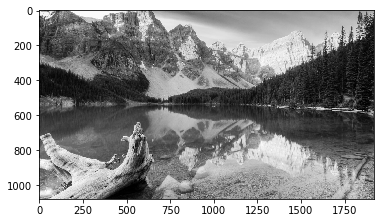

In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/content/drive/My Drive/Wallpaper-1080P-15.jpg'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

### Define and visualize the filters

In [0]:
import numpy as np

filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [0]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


### Define convolutional and pooling layers

You've seen how to define a convolutional layer, next is a:
* Pooling layer

In the next cell, 
1. we initialize a convolutional layer so that it contains all the created filters. 
2. Then add a maxpooling layer, [documented here](http://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html), with a kernel size of (2x2) 
  - so you can see that the image resolution has been reduced after this step!

**maxpooling layer** 
- reduces the x-y size of an input and only keeps the most *active* pixel values. 

Below is an example of a 2x2 pooling kernel, with a stride of 2, applied to a small patch of grayscale pixel values; reducing the x-y size of the patch by a factor of 2. Only the maximum pixel values in 2x2 remain in the new, pooled output.

![max pooling](https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/conv-visualization/notebook_ims/maxpooling_ex.png?raw=true)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:] # weight.shape[2:] returns 'torch.Size([4, 4])'
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        # define a pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
print("Weight:\n", weight)

# feed the weight in the model
model = Net(weight)

# print out the layer in the network
print(model)

Weight:
 tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]])
Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Visualize the output of each filter

First, we'll define a helper function, `viz_layer` that takes in a specific layer and number of filters (optional argument), and displays the output of that layer once an image has been passed through.

In [0]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Let's look at the output of a convolutional layer after a ReLu activation function is applied.

#### ReLu activation

A ReLu function turns all negative pixel values in 0's (black). See the equation pictured below for input pixel values, `x`. 

![relu](https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/conv-visualization/notebook_ims/relu_ex.png?raw=true)

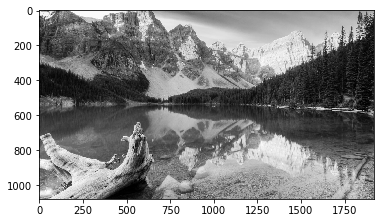

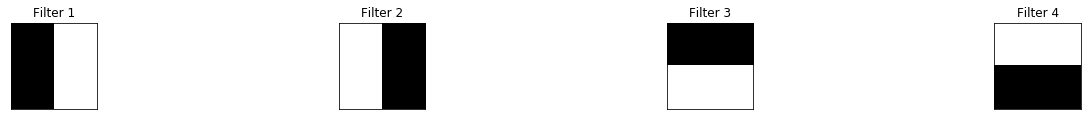

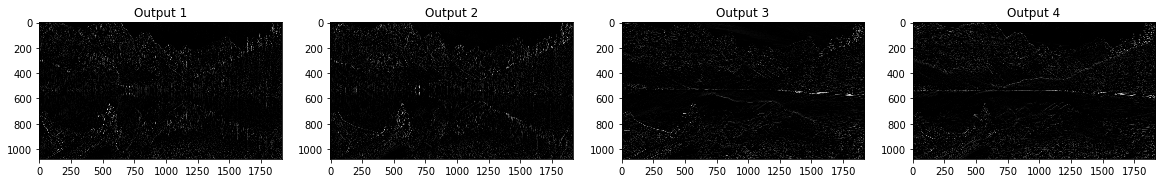

In [0]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(activated_layer)

In [0]:
activated_layer.shape

torch.Size([1, 4, 1077, 1917])

### Visualize the output of the pooling layer

Then, take a look at the output of a pooling layer. The pooling layer takes as input the feature maps pictured above and reduces the dimensionality of those maps, by some pooling factor, by constructing a new, smaller image of only the maximum (brightest) values in a given kernel area.

Take a look at the values on the x, y axes to see how the image has changed size.
In addition, we can see that the shape of the images are reduced!


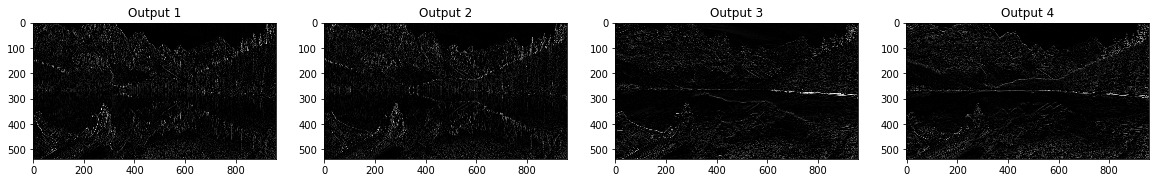

In [0]:
# visualize the output of the pooling layer
viz_layer(pooled_layer)

In [0]:
pooled_layer.shape

torch.Size([1, 4, 538, 958])